In [1]:
import os
import pickle

import seaborn as sns
import pandas as pd
import numpy as np

import sklearn
from sklearn.metrics import *
from sklearn.tree import *
from sklearn.ensemble import *
from sklearn.feature_selection import *
from sklearn.metrics import matthews_corrcoef, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline

from scipy.stats import uniform, truncnorm, randint
from scipy.stats import spearmanr, pearsonr
from scipy.stats import ttest_ind, shapiro, wilcoxon

from statsmodels.stats.outliers_influence import variance_inflation_factor
from mlxtend import feature_selection

import warnings
warnings.filterwarnings('ignore')

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import gc
gc.collect()

8

In [2]:
DATA_FOLDER = "data/"
CSV_FOLDER = "csv/"

Xs_train, ys_train = dict(), dict()
Xs_test, ys_test = dict(), dict()

spearman_data = dict()

PAIRS = [['camel-1.4', 'camel-1.6'], ['jedit-4.0', 'jedit-4.1'], ['lucene-2.0', 'lucene-2.2'], \
         ['poi-2.5', 'poi-3.0'], ['synapse-1.1', 'synapse-1.2'], ['xalan-2.5', 'xalan-2.6'], ['xerces-1.2', 'xerces-1.3']]

COLUMN_METRICS = ['name.1', 'wmc', 'dit', 'noc', 'cbo', 'rfc', 'lcom', 'ca', 'ce', 'npm', 'lcom3', 'loc', 'dam', 'moa', 'mfa', 'cam', 'ic', 'cbm', 'amc', 'max_cc', 'avg_cc', 'bug']
PROPOSED_METRICS = ["NS", "ND", "NF", "ENT", "LA", "LD", "LT", "FIX", "NDEV", "AGE", "NUC", "EXP", "REXP", "SEXP"]
PROCESS_METRICS = ["add", "del", "adev", "comm", "gexp"]

In [3]:
for pair in PAIRS:
    
    train_name, test_name = pair
    
    proj_name = train_name.split("-")[0]
    
    # train set
    
    pm_vectors = pd.read_csv(os.path.join("pm", train_name + ".csv"), names=['name'] + PROCESS_METRICS + ['bug'])
    pm_vectors = pm_vectors.drop(['bug'], axis=1)
    
    apm_vectors = pd.read_csv(os.path.join(CSV_FOLDER, train_name + ".csv"), names=['name'] + PROPOSED_METRICS + ['bug'])
    apm_vectors = apm_vectors.drop(['bug'], axis=1)
    existing = list(apm_vectors['name'].values)
    
    traditional_vectors = pd.read_csv(os.path.join(DATA_FOLDER, train_name + ".csv"))
    traditional_vectors = traditional_vectors.rename(columns={'name.1':'module'})
    traditional_vectors = traditional_vectors.drop(['name', 'version'], axis=1)
    traditional_vectors = traditional_vectors.rename(columns={'module':'name'})
    traditional_vectors.loc[(traditional_vectors['bug'] >= 1), 'bug'] = 1
    traditional_vectors = traditional_vectors.loc[traditional_vectors['name'].isin(existing)]
    
    both_process_and_proposed_vectors = pd.merge(pm_vectors, apm_vectors, on='name')
    all_features_vectors = pd.merge(both_process_and_proposed_vectors, traditional_vectors, on='name')
    all_features_vectors = all_features_vectors.drop(['name'], axis=1)
    spearman_data[proj_name] = all_features_vectors
    X, y = all_features_vectors.values[:,:-1], all_features_vectors.values[:,-1]
    Xs_train[proj_name] = X
    ys_train[proj_name] = y
    
    # the same for test set
    
    pm_vectors = pd.read_csv(os.path.join("pm", test_name + ".csv"), names=['name'] + PROCESS_METRICS + ['bug'])
    pm_vectors = pm_vectors.drop(['bug'], axis=1)

    apm_vectors = pd.read_csv(os.path.join(CSV_FOLDER, test_name + ".csv"), names=['name'] + PROPOSED_METRICS + ['bug'])
    apm_vectors = apm_vectors.drop(['bug'], axis=1)
    existing = list(apm_vectors['name'].values)
    
    traditional_vectors = pd.read_csv(os.path.join(DATA_FOLDER, test_name + ".csv"))
    traditional_vectors = traditional_vectors.rename(columns={'name.1':'module'})
    traditional_vectors = traditional_vectors.drop(['name', 'version'], axis=1)
    traditional_vectors = traditional_vectors.rename(columns={'module':'name'})
    traditional_vectors.loc[(traditional_vectors['bug'] >= 1), 'bug'] = 1
    traditional_vectors = traditional_vectors.loc[traditional_vectors['name'].isin(existing)]
    
    both_process_and_proposed_vectors = pd.merge(pm_vectors, apm_vectors, on='name')
    all_features_vectors = pd.merge(both_process_and_proposed_vectors, traditional_vectors, on='name')
    all_features_vectors = all_features_vectors.drop(['name'], axis=1)

    X, y = all_features_vectors.values[:,:-1], all_features_vectors.values[:,-1]

    Xs_test[proj_name] = X
    ys_test[proj_name] = y

# RQ1

In [6]:
COLUMNS = ["add", "del", "adev", "comm", "gexp", r'$\overrightarrow{\mathrm{NS}}$', r'$\overrightarrow{\mathrm{ND}}$', r'$\overrightarrow{\mathrm{NF}}$', r'$\overrightarrow{\mathrm{ENT}}$', r'$\overrightarrow{\mathrm{LA}}$', r'$\overrightarrow{\mathrm{LD}}$', r'$\overrightarrow{\mathrm{LT}}$', r'$\overrightarrow{\mathrm{FIX}}$', r'$\overrightarrow{\mathrm{NDEV}}$', r'$\overrightarrow{\mathrm{AGE}}$',
       r'$\overrightarrow{\mathrm{NUC}}$', r'$\overrightarrow{\mathrm{EXP}}$', r'$\overrightarrow{\mathrm{REXP}}$', r'$\overrightarrow{\mathrm{SEXP}}$', 'wmc', 'dit', 'noc', 'cbo', 'rfc', 'lcom',
       'ca', 'ce', 'npm', 'lcom3', 'loc', 'dam', 'moa', 'mfa', 'cam', 'ic',
       'cbm', 'amc', 'max_cc', 'avg_cc', 'bug']


for i in range(21):
    COLUMNS[len(COLUMNS) - (i+1)] = "$\mathrm{" + COLUMNS[len(COLUMNS) - (i+1)].upper() + "}$"

big_table = []

ALPHA = 0.05

for name, table in spearman_data.items():

        t = table.fillna(-1)
        big_table.extend(t.values)

big_table = np.array(big_table).reshape((-1, 40))

RESULTS = dict()

for e, k in enumerate(COLUMNS):
    
    coef, p = spearmanr(big_table[:,e], big_table[:,-1])
    if p <= 0.05:
        RESULTS[COLUMNS[e]] = coef

results = {k: v for k, v in sorted(RESULTS.items(), key=lambda item: -1 * np.mean(item[1]))}
del results["$\mathrm{BUG}$"]

MOST_CORRELATED = list()

for k, v in results.items():
    if abs(v) > 0.19:
        MOST_CORRELATED.append((COLUMNS.index(k), k))
    print("{:10}".format(k),":", "{:.2f}".format(v))

$\overrightarrow{\mathrm{LT}}$ : 0.36
$\mathrm{NPM}$ : 0.26
$\mathrm{LOC}$ : 0.26
$\mathrm{WMC}$ : 0.26
$\overrightarrow{\mathrm{NF}}$ : 0.25
$\mathrm{RFC}$ : 0.23
$\overrightarrow{\mathrm{NS}}$ : 0.23
$\overrightarrow{\mathrm{LD}}$ : 0.23
$\mathrm{LCOM}$ : 0.22
$\overrightarrow{\mathrm{ND}}$ : 0.22
$\overrightarrow{\mathrm{AGE}}$ : 0.21
$\mathrm{CBM}$ : 0.20
comm       : 0.18
$\overrightarrow{\mathrm{NUC}}$ : 0.18
$\mathrm{MAX_CC}$ : 0.15
del        : 0.14
$\mathrm{AMC}$ : 0.14
$\mathrm{IC}$ : 0.14
$\overrightarrow{\mathrm{NDEV}}$ : 0.14
adev       : 0.13
$\mathrm{MOA}$ : 0.10
$\mathrm{CE}$ : 0.08
$\overrightarrow{\mathrm{LA}}$ : 0.07
$\mathrm{AVG_CC}$ : 0.07
$\mathrm{DIT}$ : 0.07
$\mathrm{CBO}$ : 0.07
$\mathrm{CA}$ : 0.05
$\overrightarrow{\mathrm{FIX}}$ : -0.06
$\overrightarrow{\mathrm{SEXP}}$ : -0.09
$\mathrm{CAM}$ : -0.13
$\overrightarrow{\mathrm{EXP}}$ : -0.13
add        : -0.14
gexp       : -0.15
$\overrightarrow{\mathrm{REXP}}$ : -0.17
$\overrightarrow{\mathrm{ENT}}$ : -0.21


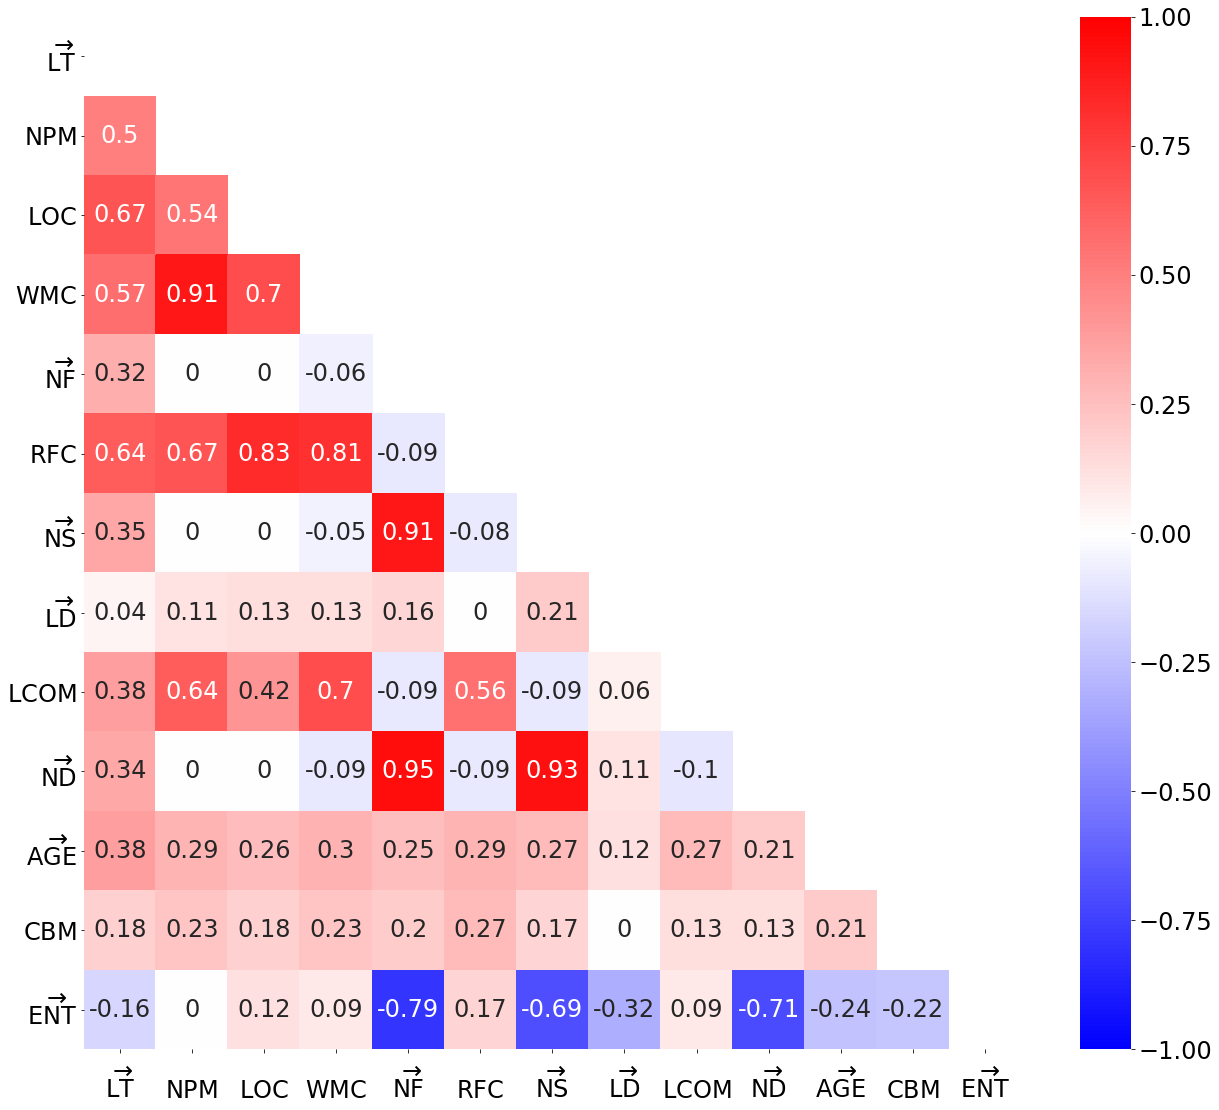

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D
import matplotlib.font_manager as font_manager

plt.rcParams["figure.figsize"] = (15,15)
plt.rcParams["font.family"] = "Century"
plt.rcParams["font.size"] = 24
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.labelsize'] = 24
plt.rcParams.update({'font.size':24})
plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 24
plt.rcParams['text.usetex']=False

big_table = []
ALPHA = 0.05

for name, table in spearman_data.items():

        t = table.fillna(-1)
        big_table.extend(t.values)
        
big_table = np.array(big_table).reshape((-1, 40))


RESULTS = dict()

for (e, k) in MOST_CORRELATED:
    for (ee, kk) in MOST_CORRELATED:
        if e < ee:
            if (shapiro(big_table[:,e]).pvalue > ALPHA) and (shapiro(big_table[:,ee]).pvalue > ALPHA):
                # normally distributed
                coef, p = pearsonr(big_table[:,e], big_table[:,ee])
                if p <= 0.05:
                    RESULTS[COLUMNS[e] + "," + COLUMNS[ee]] = round(coef, 2)
            else:
                coef, p = spearmanr(big_table[:,e], big_table[:,ee])
                if p <= 0.05:
                    RESULTS[COLUMNS[e] + "," + COLUMNS[ee]] = round(coef, 2)
            

results = {k: v for k, v in sorted(RESULTS.items(), key=lambda item: -1 * np.mean(item[1]))}


correlation_matrix = np.eye(N=len(MOST_CORRELATED))

for k, v in results.items():
    a, b = int(MOST_CORRELATED.index((COLUMNS.index(k.split(",")[0]), k.split(",")[0]))), int(MOST_CORRELATED.index((COLUMNS.index(k.split(",")[1]), k.split(",")[1])))
    correlation_matrix[a][b] = v
    correlation_matrix[b][a] = v

corr = pd.DataFrame(correlation_matrix, index=[i[1] for i in MOST_CORRELATED], columns=[i[1] for i in MOST_CORRELATED])

mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(21, 19))
cmap = sns.diverging_palette(250, 350, s=100, as_cmap=True)

sns.heatmap(corr, mask=mask, annot=True, cmap='bwr', vmin=-1, vmax=1)
plt.yticks(rotation = 0)
plt.xticks(va='baseline', position=(0, -0.04))
plt.show()
#plt.savefig('correlation_btwn_features.pdf',bbox_inches = 'tight', pad_inches = 0)

# RQ2 - model evaluation

In [9]:
from copy import deepcopy

def autospearman(set_of_metrics, spearman_threshold, vif_threshold):
    size = set_of_metrics.shape[1]
    removed = set()
    
    spearman_coefficients = dict()
    
    for i in range(size):
        for j in range(size):
            if i < j and i != j:
                coef, p = spearmanr(set_of_metrics[:, i], set_of_metrics[:, j])
                if p <= 0.05 and np.abs(coef) >= spearman_threshold:
                    spearman_coefficients[str(i) + "," + str(j)] = coef
    
    spearman_coefficients = {k: v for k, v in sorted(spearman_coefficients.items(), key=lambda item: -1 * item[1])}  
    
    while True:
        
        if len(list(spearman_coefficients.keys())) == 0: break
        
        to_remove = None
        
        for k, v in spearman_coefficients.items():
            i, j = k.split(",")

            with_i = [k for k, v in spearman_coefficients.items() if k.split(",")[0] == i or k.split(",")[1] == i]
            with_j = [k for k, v in spearman_coefficients.items() if k.split(",")[0] == j or k.split(",")[1] == j]

            calc_i = np.mean([np.abs(spearman_coefficients[k]) for k in with_i])
            calc_j = np.mean([np.abs(spearman_coefficients[k]) for k in with_j])
            
            to_remove = i
            if calc_i < calc_j:
                to_remove = j
            break
        
        temp_keys = list(spearman_coefficients.keys())
        temp_keys = [k for k in spearman_coefficients if k.split(",")[0].strip() == to_remove or k.split(",")[1].strip() == to_remove]

        for k in temp_keys:
            del spearman_coefficients[k]

        removed.add(int(to_remove))

    new_set_of_metrics = set_of_metrics[:, [i for i in range(size) if i not in removed]]
    
    delta = [i for i in range(size) if i not in removed]
    mapping = dict(zip(delta, [i for i in range(len(delta))]))
        
    while True:
        
        vif_dict = dict()
        
        rest = [i for i in range(size) if i not in removed]
        
        for i in rest:
            temp = variance_inflation_factor(new_set_of_metrics, mapping[i])
            if temp >= vif_threshold:
                vif_dict[i] = temp
        
        if len(vif_dict) == 0: break
        
        vif_dict = {k: v for k, v in sorted(vif_dict.items(), key=lambda item: -1 * item[1])}  
        
        for k, v in vif_dict.items():
            removed.add(k)
            break
            
        new_set_of_metrics = set_of_metrics[:, [i for i in range(size) if i not in removed]]
        
        delta = [i for i in range(size) if i not in removed]
        mapping = dict(zip(delta, [i for i in range(len(delta))]))
     
    
    ret = set_of_metrics[:, [i for i in range(size) if i not in removed]]
    
    return removed, ret

In [10]:
def get_score(model, data, gt):
    y_predicted = model.predict(data)
    mcc = matthews_corrcoef(gt, y_predicted)
    auc = roc_auc_score(gt, y_predicted)
    f1 = f1_score(gt, y_predicted)
    print("{:.2f}".format(mcc), "{:.2f}".format(auc), "{:.2f}".format(f1))
    return mcc, auc, f1

In [11]:
ALPHA = 0.05

params = {'svm__svm__C': uniform(1e-5, 1e10),
          'svm__svm__gamma': uniform(1e-8, 1e5),
          'lda__solver': ['svd', 'lsqr', 'eigen'],
          'rfc__max_depth': range(10, 50, 5),
          'rfc__n_estimators': range(10, 500, 10),
          'mlp__mlp__hidden_layer_sizes': range(10, 50, 10)}

PROPOSED_MODEL_MCC_SCORES, PROPOSED_MODEL_AUC_SCORES, PROPOSED_MODEL_F1_SCORES = dict(), dict(), dict()
TRADITIONAL_MODEL_MCC_SCORES, TRADITIONAL_MODEL_AUC_SCORES, TRADITIONAL_MODEL_F1_SCORES = dict(), dict(), dict()

In [12]:
gc.collect()

64

# FIRST SETTING

In [13]:
for pair in PAIRS:
    
    gc.collect()
    
    train_name, test_name = pair
    
    proj_name = train_name.split("-")[0]
    print(proj_name)
    
    if proj_name not in PROPOSED_MODEL_MCC_SCORES:
        PROPOSED_MODEL_MCC_SCORES[proj_name] = []
        PROPOSED_MODEL_AUC_SCORES[proj_name] = []
        PROPOSED_MODEL_F1_SCORES[proj_name] = []
        TRADITIONAL_MODEL_MCC_SCORES[proj_name] = []
        TRADITIONAL_MODEL_AUC_SCORES[proj_name] = []
        TRADITIONAL_MODEL_F1_SCORES[proj_name] = []
        AGM_MODEL_MCC_SCORES[proj_name] = []
        AGM_MODEL_AUC_SCORES[proj_name] = []
        AGM_MODEL_F1_SCORES[proj_name] = []
    
    # traditional only
    indices = list(range(5))
    indices.extend(range(19,39,1))
    X_train, X_test = np.nan_to_num(Xs_train[proj_name][:, indices]), np.nan_to_num(Xs_test[proj_name][:, indices])
    y_train, y_test = ys_train[proj_name], ys_test[proj_name]
    
    removed, X_train = autospearman(X_train, 0.6, 10)
    kept = [i for i in range(Xs_train[proj_name][:, indices].shape[1]) if i not in removed]
    X_test = X_test[:, kept]
    
    for _ in range(100):

        clf1 = RandomForestClassifier()
        clf2 = LinearDiscriminantAnalysis()
        clf3 = Pipeline([('', StandardScaler()), ('svm', SVC(probability=True))])
        clf4 = Pipeline([('', StandardScaler()), ('mlp', MLPClassifier())])

        eclf = VotingClassifier(estimators=[
            ('rfc', clf1),
            ('lda', clf2),
            ('svm', clf3),
            ('mlp', clf4)], voting='soft')
        
        clf = RandomizedSearchCV(eclf, params, n_iter=10, n_jobs=-1, cv=5, scoring='roc_auc', random_state=_, refit=True)
        model = clf.fit(X_train, y_train)
        mcc, auc, f1 = get_score(model, X_test, y_test)

        TRADITIONAL_MODEL_MCC_SCORES[proj_name].append(mcc)
        TRADITIONAL_MODEL_AUC_SCORES[proj_name].append(auc)
        TRADITIONAL_MODEL_F1_SCORES[proj_name].append(f1)

        del clf1
        del clf2
        del clf3
        del clf4
        del clf
        del model
    
    
    # all features
    indices = list(range(5, 39, 1))
    
    X_train, X_test = np.nan_to_num(Xs_train[proj_name][:, indices]), np.nan_to_num(Xs_test[proj_name][:, indices])
    y_train, y_test = ys_train[proj_name], ys_test[proj_name]
    
    removed, X_train = autospearman(X_train, 0.6, 10)
    kept = [i for i in range(Xs_train[proj_name][:, indices].shape[1]) if i not in removed]
    X_test = X_test[:, kept]
    
    for _ in range(100):

        clf1 = RandomForestClassifier()
        clf2 = LinearDiscriminantAnalysis()
        clf3 = Pipeline([('', StandardScaler()), ('svm', SVC(probability=True))])
        clf4 = Pipeline([('', StandardScaler()), ('mlp', MLPClassifier())])

        eclf = VotingClassifier(estimators=[
            ('rfc', clf1),
            ('lda', clf2),
            ('svm', clf3),
            ('mlp', clf4)], voting='soft')
        
        clf = RandomizedSearchCV(eclf, params, n_iter=100, n_jobs=-1, cv=5, scoring='roc_auc', random_state=_, refit=True)
        model = clf.fit(X_train, y_train)
        mcc, auc, f1 = get_score(model, X_test, y_test)

        PROPOSED_MODEL_MCC_SCORES[proj_name].append(mcc)
        PROPOSED_MODEL_AUC_SCORES[proj_name].append(auc)
        PROPOSED_MODEL_F1_SCORES[proj_name].append(f1)

        del clf1
        del clf2
        del clf3
        del clf4
        del clf
        del model

camel


NameError: name 'AGM_MODEL_MCC_SCORES' is not defined

In [8]:
mcc_agg = {"0":[], "1":[]}
mcc_agg_ = {"0":[], "1":[]}

auc_agg = {"0":[], "1":[]}
auc_agg_ = {"0":[], "1":[]}

f1_agg = {"0":[], "1":[]}
f1_agg_ = {"0":[], "1":[]}


print("MCC" + " "*7, "\t   trad+proc", "\t  trad+prop")
for k, v in TRADITIONAL_MODEL_MCC_SCORES.items():
    cnt = 0

    print("{:10}".format(k), end="\t")
    print("{:.2f} +/- {:.2f}".format(np.average(np.array(v)), np.std(np.array(v))), end ="\t")

    mcc_agg[str(cnt)].append(np.average(np.array(v)))
    mcc_agg_[str(cnt)].append(np.std(np.array(v)))
    cnt += 1

    model_1_results = v

    vv = PROPOSED_MODEL_MCC_SCORES[k]
    print("{:.2f} +/- {:.2f}".format(np.average(np.array(vv)), np.std(np.array(vv))), end="\t")

    mcc_agg[str(cnt)].append(np.average(np.array(vv)))
    mcc_agg_[str(cnt)].append(np.std(np.array(vv)))

    model_2_results = vv

    model_result = [model_1_results[i] - model_2_results[i] for i in range(len(model_1_results))]

    if ( (shapiro(model_1_results).pvalue > ALPHA) and (shapiro(model_2_results).pvalue > ALPHA) ):
        # normally distributed
        print(ttest_ind(model_1_results, model_2_results).pvalue < ALPHA, "(", ttest_ind(model_1_results, model_2_results).pvalue ,")")
    else:
        print(wilcoxon(model_1_results, model_2_results).pvalue < ALPHA, "(", ttest_ind(model_1_results, model_2_results).pvalue ,")") 

print("-"*45)
print("{:10}".format("average"), end="\t")
for i in range(2):
    vv = mcc_agg[str(i)]
    vvv = mcc_agg_[str(i)]
    print("{:.2f} +/- {:.2f}".format(np.average(np.array(vv)), np.average(np.array(vvv))), end ="\t")
print()
print("-"*45)  
print()

print("AUC" + " "*7, "\t   trad+proc", "\t  trad+prop")
for k, v in TRADITIONAL_MODEL_AUC_SCORES.items():
    cnt = 0

    print("{:10}".format(k), end="\t")
    print("{:.2f} +/- {:.2f}".format(np.average(np.array(v)), np.std(np.array(v))), end ="\t")

    auc_agg[str(cnt)].append(np.average(np.array(v)))
    auc_agg_[str(cnt)].append(np.std(np.array(v)))
    cnt += 1

    model_1_results = v

    vv = PROPOSED_MODEL_AUC_SCORES[k]
    print("{:.2f} +/- {:.2f}".format(np.average(np.array(vv)), np.std(np.array(vv))), end="\t")

    auc_agg[str(cnt)].append(np.average(np.array(vv)))
    auc_agg_[str(cnt)].append(np.std(np.array(vv)))

    model_2_results = vv

    model_result = [model_1_results[i] - model_2_results[i] for i in range(len(model_1_results))]

    if ( (shapiro(model_1_results).pvalue > ALPHA) and (shapiro(model_2_results).pvalue > ALPHA) ):
        # normally distributed
        print(ttest_ind(model_1_results, model_2_results).pvalue < ALPHA, "(", ttest_ind(model_1_results, model_2_results).pvalue ,")")
    else:
        print(wilcoxon(model_1_results, model_2_results).pvalue < ALPHA, "(", ttest_ind(model_1_results, model_2_results).pvalue ,")") 

print("-"*45)
print("{:10}".format("average"), end="\t")
for i in range(2):
    vv = auc_agg[str(i)]
    vvv = auc_agg_[str(i)]
    print("{:.2f} +/- {:.2f}".format(np.average(np.array(vv)), np.average(np.array(vvv))), end ="\t")
print()
print("-"*45)
print()

print("F1" + " "*7, "\t   trad+proc", "\t  trad+prop")
for k, v in TRADITIONAL_MODEL_F1_SCORES.items():
    cnt = 0

    print("{:10}".format(k), end="\t")
    print("{:.2f} +/- {:.2f}".format(np.average(np.array(v)), np.std(np.array(v))), end ="\t")

    f1_agg[str(cnt)].append(np.average(np.array(v)))
    f1_agg_[str(cnt)].append(np.std(np.array(v)))
    cnt += 1

    model_1_results = v

    vv = PROPOSED_MODEL_F1_SCORES[k]
    print("{:.2f} +/- {:.2f}".format(np.average(np.array(vv)), np.std(np.array(vv))), end="\t")

    f1_agg[str(cnt)].append(np.average(np.array(vv)))
    f1_agg_[str(cnt)].append(np.std(np.array(vv)))

    model_2_results = vv

    model_result = [model_1_results[i] - model_2_results[i] for i in range(len(model_1_results))]

    if ( (shapiro(model_1_results).pvalue > ALPHA) and (shapiro(model_2_results).pvalue > ALPHA) ):
        # normally distributed
        print(ttest_ind(model_1_results, model_2_results).pvalue < ALPHA, "(", ttest_ind(model_1_results, model_2_results).pvalue ,")")
    else:
        print(wilcoxon(model_1_results, model_2_results).pvalue < ALPHA, "(", ttest_ind(model_1_results, model_2_results).pvalue ,")") 

print("-"*45)
print("{:10}".format("average"), end="\t")
for i in range(2):
    vv = f1_agg[str(i)]
    vvv = f1_agg_[str(i)]
    print("{:.2f} +/- {:.2f}".format(np.average(np.array(vv)), np.average(np.array(vvv))), end ="\t")
print()
print("-"*45) 

MCC        	   trad+proc 	  trad+prop
camel     	0.23 +/- 0.01	0.18 +/- 0.01	True ( 1.526699788585111e-23 )
jedit     	0.39 +/- 0.02	0.37 +/- 0.01	True ( 0.001175204574720597 )
lucene    	-0.03 +/- 0.02	0.06 +/- 0.02	True ( 3.764634336323219e-23 )
poi       	-0.06 +/- 0.01	0.32 +/- 0.01	True ( 1.5387102824599875e-75 )
synapse   	0.16 +/- 0.02	0.11 +/- 0.05	True ( 4.867471430489313e-06 )
xalan     	0.11 +/- 0.01	0.24 +/- 0.02	True ( 1.5597219852292107e-34 )
xerces    	0.10 +/- 0.02	0.13 +/- 0.03	True ( 5.089227372429312e-06 )
---------------------------------------------
average   	0.13 +/- 0.02	0.20 +/- 0.02	
---------------------------------------------

AUC        	   trad+proc 	  trad+prop
camel     	0.55 +/- 0.00	0.56 +/- 0.01	True ( 1.7769181047445006e-05 )
jedit     	0.68 +/- 0.01	0.63 +/- 0.01	True ( 2.135472215657652e-27 )
lucene    	0.49 +/- 0.01	0.52 +/- 0.01	True ( 4.97502964129318e-19 )
poi       	0.49 +/- 0.00	0.64 +/- 0.01	True ( 3.489773089146445e-63 )
synapse   	0.55 +/

# SECOND SETTING

In [ ]:
PROPOSED_MODEL_MCC_SCORES, PROPOSED_MODEL_AUC_SCORES, PROPOSED_MODEL_F1_SCORES = dict(), dict(), dict()
TRADITIONAL_MODEL_MCC_SCORES, TRADITIONAL_MODEL_AUC_SCORES, TRADITIONAL_MODEL_F1_SCORES = dict(), dict(), dict()

In [ ]:
# UNCOMMENT TO PRE-SET PARAMETERS
"""
TAKE_THIS = {
    "camel":[(0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 23, 24),(0, 1, 2, 3, 4, 10, 11, 12, 13, 15, 16, 18, 19, 20, 21, 22, 23, 26, 27, 30)],
    "jedit":[(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 14, 15, 16, 18, 19, 21, 22, 24),(0, 1, 3, 6, 7, 8, 9, 10, 14, 15, 16, 17, 18, 23, 24, 25, 26, 27, 28, 31)],
    "lucene":[(2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 21, 23, 24),(1, 8, 11, 12, 13, 15, 17, 18, 19, 20, 21, 22, 24, 25, 26, 27, 28, 30, 32, 33)],
    "poi":[(0, 1, 2, 3, 4, 5, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 21, 22, 23, 24),(0, 2, 3, 4, 5, 8, 9, 10, 11, 13, 14, 22, 23, 24, 25, 26, 28, 30, 32, 33)],
    "synapse":[(0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 12, 13, 15, 17, 18, 20, 21, 22, 23, 24),(4, 6, 7, 8, 11, 12, 13, 15, 17, 18, 19, 20, 21, 22, 24, 26, 29, 30, 31, 32)],
    "xalan":[(0, 1, 2, 4, 5, 6, 7, 9, 10, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24),(3, 4, 5, 6, 8, 9, 14, 15, 16, 19, 23, 24, 25, 26, 28, 29, 30, 31, 32, 33)],
    "xerces":[(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 16, 17, 18, 19, 20, 23), (0, 1, 2, 3, 4, 6, 8, 10, 13, 14, 16, 17, 18, 19, 20, 22, 23, 25, 29, 33)]
}
"""


for pair in PAIRS:
    
    gc.collect()
    
    train_name, test_name = pair
    
    proj_name = train_name.split("-")[0]
    print(proj_name)
    
    if proj_name not in PROPOSED_MODEL_MCC_SCORES:
        PROPOSED_MODEL_MCC_SCORES[proj_name] = []
        PROPOSED_MODEL_AUC_SCORES[proj_name] = []
        PROPOSED_MODEL_F1_SCORES[proj_name] = []
        TRADITIONAL_MODEL_MCC_SCORES[proj_name] = []
        TRADITIONAL_MODEL_AUC_SCORES[proj_name] = []
        TRADITIONAL_MODEL_F1_SCORES[proj_name] = []
    
    # traditional only
    indices = list(range(5))
    indices.extend(range(19,39,1))
    X_train, X_test = np.nan_to_num(Xs_train[proj_name][:, indices]), np.nan_to_num(Xs_test[proj_name][:, indices])
    y_train, y_test = ys_train[proj_name], ys_test[proj_name]
    
    # take these features
    #X_train = X_train[:, TAKE_THIS[proj_name][0]]
    #X_test = X_test[:, TAKE_THIS[proj_name][0]]
    
    for _ in range(100):

        clf1 = RandomForestClassifier()
        clf2 = LinearDiscriminantAnalysis()
        clf3 = Pipeline([('', StandardScaler()), ('svm', SVC(probability=True))])
        clf4 = Pipeline([('', StandardScaler()), ('mlp', MLPClassifier())])

        eclf = VotingClassifier(estimators=[
            ('rfc', clf1),
            ('lda', clf2),
            ('svm', clf3),
            ('mlp', clf4)], voting='soft')
        
        clf = RandomizedSearchCV(eclf, params, n_iter=10, n_jobs=-1, cv=5, scoring='roc_auc', random_state=_, refit=True)
        model = clf.fit(X_train, y_train)
        mcc, auc, f1 = get_score(model, X_test, y_test)

        TRADITIONAL_MODEL_MCC_SCORES[proj_name].append(mcc)
        TRADITIONAL_MODEL_AUC_SCORES[proj_name].append(auc)
        TRADITIONAL_MODEL_F1_SCORES[proj_name].append(f1)

        del clf1
        del clf2
        del clf3
        del clf4
        del clf
        del model
    

    # all features
    indices = list(range(5, 39, 1))
    
    X_train, X_test = np.nan_to_num(Xs_train[proj_name][:, indices]), np.nan_to_num(Xs_test[proj_name][:, indices])
    y_train, y_test = ys_train[proj_name], ys_test[proj_name]
    
    # take these features
    #X_train = X_train[:, TAKE_THIS[proj_name][1]]
    #X_test = X_test[:, TAKE_THIS[proj_name][1]]

    for _ in range(100):

        clf1 = RandomForestClassifier()
        clf2 = LinearDiscriminantAnalysis()
        clf3 = Pipeline([('', StandardScaler()), ('svm', SVC(probability=True))])
        clf4 = Pipeline([('', StandardScaler()), ('mlp', MLPClassifier())])

        eclf = VotingClassifier(estimators=[
            ('rfc', clf1),
            ('lda', clf2),
            ('svm', clf3),
            ('mlp', clf4)], voting='soft')
        
        clf = RandomizedSearchCV(eclf, params, n_iter=100, n_jobs=-1, cv=5, scoring='roc_auc', random_state=_, refit=True)
        model = clf.fit(X_train, y_train)
        mcc, auc, f1 = get_score(model, X_test, y_test)

        PROPOSED_MODEL_MCC_SCORES[proj_name].append(mcc)
        PROPOSED_MODEL_AUC_SCORES[proj_name].append(auc)
        PROPOSED_MODEL_F1_SCORES[proj_name].append(f1)

        del clf1
        del clf2
        del clf3
        del clf4
        del clf
        del model

In [9]:
mcc_agg = {"0":[], "1":[]}
mcc_agg_ = {"0":[], "1":[]}

auc_agg = {"0":[], "1":[]}
auc_agg_ = {"0":[], "1":[]}

f1_agg = {"0":[], "1":[]}
f1_agg_ = {"0":[], "1":[]}


print("MCC" + " "*7, "\t   trad+proc", "\t  trad+prop")
for k, v in TRADITIONAL_MODEL_MCC_SCORES.items():
    cnt = 0

    print("{:10}".format(k), end="\t")
    print("{:.2f} +/- {:.2f}".format(np.average(np.array(v)), np.std(np.array(v))), end ="\t")

    mcc_agg[str(cnt)].append(np.average(np.array(v)))
    mcc_agg_[str(cnt)].append(np.std(np.array(v)))
    cnt += 1

    model_1_results = v

    vv = PROPOSED_MODEL_MCC_SCORES[k]
    print("{:.2f} +/- {:.2f}".format(np.average(np.array(vv)), np.std(np.array(vv))), end="\t")

    mcc_agg[str(cnt)].append(np.average(np.array(vv)))
    mcc_agg_[str(cnt)].append(np.std(np.array(vv)))

    model_2_results = vv

    model_result = [model_1_results[i] - model_2_results[i] for i in range(len(model_1_results))]

    if ( (shapiro(model_1_results).pvalue > ALPHA) and (shapiro(model_2_results).pvalue > ALPHA) ):
        # normally distributed
        print(ttest_ind(model_1_results, model_2_results).pvalue < ALPHA, "(", ttest_ind(model_1_results, model_2_results).pvalue ,")")
    else:
        print(wilcoxon(model_1_results, model_2_results).pvalue < ALPHA, "(", ttest_ind(model_1_results, model_2_results).pvalue ,")") 

print("-"*45)
print("{:10}".format("average"), end="\t")
for i in range(2):
    vv = mcc_agg[str(i)]
    vvv = mcc_agg_[str(i)]
    print("{:.2f} +/- {:.2f}".format(np.average(np.array(vv)), np.average(np.array(vvv))), end ="\t")
print()
print("-"*45)  
print()

print("AUC" + " "*7, "\t   trad+proc", "\t  trad+prop")
for k, v in TRADITIONAL_MODEL_AUC_SCORES.items():
    cnt = 0

    print("{:10}".format(k), end="\t")
    print("{:.2f} +/- {:.2f}".format(np.average(np.array(v)), np.std(np.array(v))), end ="\t")

    auc_agg[str(cnt)].append(np.average(np.array(v)))
    auc_agg_[str(cnt)].append(np.std(np.array(v)))
    cnt += 1

    model_1_results = v

    vv = PROPOSED_MODEL_AUC_SCORES[k]
    print("{:.2f} +/- {:.2f}".format(np.average(np.array(vv)), np.std(np.array(vv))), end="\t")

    auc_agg[str(cnt)].append(np.average(np.array(vv)))
    auc_agg_[str(cnt)].append(np.std(np.array(vv)))

    model_2_results = vv

    model_result = [model_1_results[i] - model_2_results[i] for i in range(len(model_1_results))]

    if ( (shapiro(model_1_results).pvalue > ALPHA) and (shapiro(model_2_results).pvalue > ALPHA) ):
        # normally distributed
        print(ttest_ind(model_1_results, model_2_results).pvalue < ALPHA, "(", ttest_ind(model_1_results, model_2_results).pvalue ,")")
    else:
        print(wilcoxon(model_1_results, model_2_results).pvalue < ALPHA, "(", ttest_ind(model_1_results, model_2_results).pvalue ,")") 

print("-"*45)
print("{:10}".format("average"), end="\t")
for i in range(2):
    vv = auc_agg[str(i)]
    vvv = auc_agg_[str(i)]
    print("{:.2f} +/- {:.2f}".format(np.average(np.array(vv)), np.average(np.array(vvv))), end ="\t")
print()
print("-"*45)
print()

print("F1" + " "*7, "\t   trad+proc", "\t  trad+prop")
for k, v in TRADITIONAL_MODEL_F1_SCORES.items():
    cnt = 0

    print("{:10}".format(k), end="\t")
    print("{:.2f} +/- {:.2f}".format(np.average(np.array(v)), np.std(np.array(v))), end ="\t")

    f1_agg[str(cnt)].append(np.average(np.array(v)))
    f1_agg_[str(cnt)].append(np.std(np.array(v)))
    cnt += 1

    model_1_results = v

    vv = PROPOSED_MODEL_F1_SCORES[k]
    print("{:.2f} +/- {:.2f}".format(np.average(np.array(vv)), np.std(np.array(vv))), end="\t")

    f1_agg[str(cnt)].append(np.average(np.array(vv)))
    f1_agg_[str(cnt)].append(np.std(np.array(vv)))

    model_2_results = vv

    model_result = [model_1_results[i] - model_2_results[i] for i in range(len(model_1_results))]

    if ( (shapiro(model_1_results).pvalue > ALPHA) and (shapiro(model_2_results).pvalue > ALPHA) ):
        # normally distributed
        print(ttest_ind(model_1_results, model_2_results).pvalue < ALPHA, "(", ttest_ind(model_1_results, model_2_results).pvalue ,")")
    else:
        print(wilcoxon(model_1_results, model_2_results).pvalue < ALPHA, "(", ttest_ind(model_1_results, model_2_results).pvalue ,")") 

print("-"*45)
print("{:10}".format("average"), end="\t")
for i in range(2):
    vv = f1_agg[str(i)]
    vvv = f1_agg_[str(i)]
    print("{:.2f} +/- {:.2f}".format(np.average(np.array(vv)), np.average(np.array(vvv))), end ="\t")
print()
print("-"*45) 

MCC        	   trad+proc 	  trad+prop
camel     	0.27 +/- 0.01	0.26 +/- 0.01	True ( 0.004470546776205796 )
jedit     	0.39 +/- 0.01	0.47 +/- 0.01	True ( 7.019267522031665e-33 )
lucene    	-0.02 +/- 0.01	0.13 +/- 0.02	True ( 1.069744333716917e-40 )
poi       	0.16 +/- 0.02	0.25 +/- 0.01	True ( 5.6621262908966365e-30 )
synapse   	0.24 +/- 0.01	0.33 +/- 0.01	True ( 6.29915354226762e-33 )
xalan     	0.25 +/- 0.02	0.29 +/- 0.03	True ( 1.3925289171430774e-07 )
xerces    	0.08 +/- 0.02	0.16 +/- 0.00	True ( 9.430075104334196e-24 )
---------------------------------------------
average   	0.20 +/- 0.02	0.27 +/- 0.01	
---------------------------------------------

AUC        	   trad+proc 	  trad+prop
camel     	0.57 +/- 0.01	0.57 +/- 0.00	True ( 0.00853233563041432 )
jedit     	0.65 +/- 0.01	0.67 +/- 0.01	True ( 3.770168659050356e-13 )
lucene    	0.49 +/- 0.01	0.54 +/- 0.01	True ( 6.995555240670254e-36 )
poi       	0.55 +/- 0.01	0.63 +/- 0.01	True ( 6.832800612560544e-38 )
synapse   	0.59 +/- 0.

# THIRD SETTING

In [ ]:
params = {'max_depth': range(10, 50, 5),
          'n_estimators': range(10, 500, 10)}

In [ ]:
PROPOSED_MODEL_MCC_SCORES, PROPOSED_MODEL_AUC_SCORES, PROPOSED_MODEL_F1_SCORES = dict(), dict(), dict()
TRADITIONAL_MODEL_MCC_SCORES, TRADITIONAL_MODEL_AUC_SCORES, TRADITIONAL_MODEL_F1_SCORES = dict(), dict(), dict()

In [ ]:
for pair in PAIRS:
    
    gc.collect()
    
    train_name, test_name = pair
    
    proj_name = train_name.split("-")[0]
    print(proj_name)
    
    if proj_name not in PROPOSED_MODEL_MCC_SCORES:
        PROPOSED_MODEL_MCC_SCORES[proj_name] = []
        PROPOSED_MODEL_AUC_SCORES[proj_name] = []
        PROPOSED_MODEL_F1_SCORES[proj_name] = []
        TRADITIONAL_MODEL_MCC_SCORES[proj_name] = []
        TRADITIONAL_MODEL_AUC_SCORES[proj_name] = []
        TRADITIONAL_MODEL_F1_SCORES[proj_name] = []
    
    # traditional only
    indices = list(range(5))
    indices.extend(range(19,39,1))
    X_train, X_test = np.nan_to_num(Xs_train[proj_name][:, indices]), np.nan_to_num(Xs_test[proj_name][:, indices])
    y_train, y_test = ys_train[proj_name], ys_test[proj_name]
    
    for _ in range(100):

        clf1 = RandomForestClassifier()
        
        clf = RandomizedSearchCV(clf1, params, n_iter=100, n_jobs=-1, cv=5, scoring='roc_auc', random_state=_, refit=True)
        
        model = clf.fit(X_train, y_train)
        
        indices = np.argsort(np.array(model.best_estimator_.feature_importances_))[::-1][:20]
        X_train, X_test = X_train[:, indices], X_test[:, indices]

        clf = RandomForestClassifier(max_depth=model.best_estimator_.get_params()['max_depth'], n_estimators=model.best_estimator_.get_params()['n_estimators'])
        
        
        
        model = clf.fit(X_train, y_train)
        
        mcc, auc, f1 = get_score(model, X_test, y_test)

        TRADITIONAL_MODEL_MCC_SCORES[proj_name].append(mcc)
        TRADITIONAL_MODEL_AUC_SCORES[proj_name].append(auc)
        TRADITIONAL_MODEL_F1_SCORES[proj_name].append(f1)

        del clf1
        del clf
        del model
    
    # all features
    indices = list(range(5, 39, 1))
    
    X_train, X_test = np.nan_to_num(Xs_train[proj_name][:, indices]), np.nan_to_num(Xs_test[proj_name][:, indices])
    y_train, y_test = ys_train[proj_name], ys_test[proj_name]
    
    for _ in range(100):

        clf1 = RandomForestClassifier()
        
        clf = RandomizedSearchCV(clf1, params, n_iter=100, n_jobs=-1, cv=5, scoring='roc_auc', random_state=_, refit=True)
        
        model = clf.fit(X_train, y_train)
        
        indices = np.argsort(np.array(model.best_estimator_.feature_importances_))[::-1][:20]
        X_train, X_test = X_train[:, indices], X_test[:, indices]

        
        
        clf = RandomForestClassifier(max_depth=model.best_estimator_.get_params()['max_depth'], n_estimators=model.best_estimator_.get_params()['n_estimators'])
        
        
        
        model = clf.fit(X_train, y_train)
        mcc, auc, f1 = get_score(model, X_test, y_test)

        PROPOSED_MODEL_MCC_SCORES[proj_name].append(mcc)
        PROPOSED_MODEL_AUC_SCORES[proj_name].append(auc)
        PROPOSED_MODEL_F1_SCORES[proj_name].append(f1)

        del clf1
        del clf
        del model

In [11]:
mcc_agg = {"0":[], "1":[]}
mcc_agg_ = {"0":[], "1":[]}

auc_agg = {"0":[], "1":[]}
auc_agg_ = {"0":[], "1":[]}

f1_agg = {"0":[], "1":[]}
f1_agg_ = {"0":[], "1":[]}


print("MCC" + " "*7, "\t   trad+proc", "\t  trad+prop")
for k, v in TRADITIONAL_MODEL_MCC_SCORES.items():
    cnt = 0

    print("{:10}".format(k), end="\t")
    print("{:.2f} +/- {:.2f}".format(np.average(np.array(v)), np.std(np.array(v))), end ="\t")

    mcc_agg[str(cnt)].append(np.average(np.array(v)))
    mcc_agg_[str(cnt)].append(np.std(np.array(v)))
    cnt += 1

    model_1_results = v

    vv = PROPOSED_MODEL_MCC_SCORES[k]
    print("{:.2f} +/- {:.2f}".format(np.average(np.array(vv)), np.std(np.array(vv))), end="\t")

    mcc_agg[str(cnt)].append(np.average(np.array(vv)))
    mcc_agg_[str(cnt)].append(np.std(np.array(vv)))

    model_2_results = vv

    model_result = [model_1_results[i] - model_2_results[i] for i in range(len(model_1_results))]

    if ( (shapiro(model_1_results).pvalue > ALPHA) and (shapiro(model_2_results).pvalue > ALPHA) ):
        # normally distributed
        print(ttest_ind(model_1_results, model_2_results).pvalue < ALPHA, "(", ttest_ind(model_1_results, model_2_results).pvalue ,")")
    else:
        print(wilcoxon(model_1_results, model_2_results).pvalue < ALPHA, "(", ttest_ind(model_1_results, model_2_results).pvalue ,")") 

print("-"*45)
print("{:10}".format("average"), end="\t")
for i in range(2):
    vv = mcc_agg[str(i)]
    vvv = mcc_agg_[str(i)]
    print("{:.2f} +/- {:.2f}".format(np.average(np.array(vv)), np.average(np.array(vvv))), end ="\t")
print()
print("-"*45)  
print()

print("AUC" + " "*7, "\t   trad+proc", "\t  trad+prop")
for k, v in TRADITIONAL_MODEL_AUC_SCORES.items():
    cnt = 0

    print("{:10}".format(k), end="\t")
    print("{:.2f} +/- {:.2f}".format(np.average(np.array(v)), np.std(np.array(v))), end ="\t")

    auc_agg[str(cnt)].append(np.average(np.array(v)))
    auc_agg_[str(cnt)].append(np.std(np.array(v)))
    cnt += 1

    model_1_results = v

    vv = PROPOSED_MODEL_AUC_SCORES[k]
    print("{:.2f} +/- {:.2f}".format(np.average(np.array(vv)), np.std(np.array(vv))), end="\t")

    auc_agg[str(cnt)].append(np.average(np.array(vv)))
    auc_agg_[str(cnt)].append(np.std(np.array(vv)))

    model_2_results = vv

    model_result = [model_1_results[i] - model_2_results[i] for i in range(len(model_1_results))]

    if ( (shapiro(model_1_results).pvalue > ALPHA) and (shapiro(model_2_results).pvalue > ALPHA) ):
        # normally distributed
        print(ttest_ind(model_1_results, model_2_results).pvalue < ALPHA, "(", ttest_ind(model_1_results, model_2_results).pvalue ,")")
    else:
        print(wilcoxon(model_1_results, model_2_results).pvalue < ALPHA, "(", ttest_ind(model_1_results, model_2_results).pvalue ,")") 

print("-"*45)
print("{:10}".format("average"), end="\t")
for i in range(2):
    vv = auc_agg[str(i)]
    vvv = auc_agg_[str(i)]
    print("{:.2f} +/- {:.2f}".format(np.average(np.array(vv)), np.average(np.array(vvv))), end ="\t")
print()
print("-"*45)
print()

print("F1" + " "*7, "\t   trad+proc", "\t  trad+prop")
for k, v in TRADITIONAL_MODEL_F1_SCORES.items():
    cnt = 0

    print("{:10}".format(k), end="\t")
    print("{:.2f} +/- {:.2f}".format(np.average(np.array(v)), np.std(np.array(v))), end ="\t")

    f1_agg[str(cnt)].append(np.average(np.array(v)))
    f1_agg_[str(cnt)].append(np.std(np.array(v)))
    cnt += 1

    model_1_results = v

    vv = PROPOSED_MODEL_F1_SCORES[k]
    print("{:.2f} +/- {:.2f}".format(np.average(np.array(vv)), np.std(np.array(vv))), end="\t")

    f1_agg[str(cnt)].append(np.average(np.array(vv)))
    f1_agg_[str(cnt)].append(np.std(np.array(vv)))

    model_2_results = vv

    model_result = [model_1_results[i] - model_2_results[i] for i in range(len(model_1_results))]

    if ( (shapiro(model_1_results).pvalue > ALPHA) and (shapiro(model_2_results).pvalue > ALPHA) ):
        # normally distributed
        print(ttest_ind(model_1_results, model_2_results).pvalue < ALPHA, "(", ttest_ind(model_1_results, model_2_results).pvalue ,")")
    else:
        print(wilcoxon(model_1_results, model_2_results).pvalue < ALPHA, "(", ttest_ind(model_1_results, model_2_results).pvalue ,")") 

print("-"*45)
print("{:10}".format("average"), end="\t")
for i in range(2):
    vv = f1_agg[str(i)]
    vvv = f1_agg_[str(i)]
    print("{:.2f} +/- {:.2f}".format(np.average(np.array(vv)), np.average(np.array(vvv))), end ="\t")
print()
print("-"*45) 

MCC        	   trad+proc 	  trad+prop
camel     	0.18 +/- 0.01	0.24 +/- 0.01	True ( 2.2997479536096533e-32 )
jedit     	0.40 +/- 0.02	0.48 +/- 0.01	True ( 1.2861851822817951e-21 )
lucene    	0.18 +/- 0.02	0.25 +/- 0.01	True ( 1.875230830094646e-27 )
poi       	0.24 +/- 0.02	0.24 +/- 0.01	False ( 0.9286841826221148 )
synapse   	0.25 +/- 0.01	0.26 +/- 0.01	True ( 0.0004181994080432741 )
xalan     	0.38 +/- 0.02	0.41 +/- 0.01	True ( 5.5624017348310424e-11 )
xerces    	-0.00 +/- 0.03	0.24 +/- 0.02	True ( 3.1411989930609865e-44 )
---------------------------------------------
average   	0.23 +/- 0.02	0.30 +/- 0.01	
---------------------------------------------

AUC        	   trad+proc 	  trad+prop
camel     	0.57 +/- 0.01	0.59 +/- 0.01	True ( 1.57852325932487e-15 )
jedit     	0.69 +/- 0.01	0.71 +/- 0.01	True ( 3.110614621455392e-09 )
lucene    	0.59 +/- 0.01	0.63 +/- 0.01	True ( 1.4031756383335288e-23 )
poi       	0.62 +/- 0.01	0.62 +/- 0.01	False ( 0.42943314715673064 )
synapse   	0.60 +/-

# FORTH SETTING

In [ ]:
params = {'C': np.logspace(0, 5, num=10),
          'penalty': ['l1', 'l2'],
          'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}
params = {'C': uniform(1e-5, 1e5), 
          'gamma': uniform(1e-5, 1e5),
          'kernel': ['rbf', 'poly', 'sigmoid']}
params = {"max_depth": range(10, 50, 5),
          "max_features": range(1, 20, 1),
          "min_samples_leaf": randint(1, 9),
          "criterion": ["gini", "entropy"]}
params = {'hidden_layer_sizes': range(10, 50, 10),
          'activation': ['identity', 'logistic', 'tanh', 'relu'],
          'solver': ['sgd', 'adam'],
          'alpha': uniform(1e-5, 1e-1),
          'learning_rate': ['constant','adaptive'],}

In [ ]:
PROPOSED_MODEL_MCC_SCORES, PROPOSED_MODEL_AUC_SCORES, PROPOSED_MODEL_F1_SCORES = dict(), dict(), dict()
TRADITIONAL_MODEL_MCC_SCORES, TRADITIONAL_MODEL_AUC_SCORES, TRADITIONAL_MODEL_F1_SCORES = dict(), dict(), dict()

In [ ]:
for pair in PAIRS:
        
    gc.collect()
    
    train_name, test_name = pair
    
    proj_name = train_name.split("-")[0]
    print(proj_name)

    
    if proj_name not in PROPOSED_MODEL_MCC_SCORES:
        PROPOSED_MODEL_MCC_SCORES[proj_name] = []
        PROPOSED_MODEL_AUC_SCORES[proj_name] = []
        PROPOSED_MODEL_F1_SCORES[proj_name] = []
        TRADITIONAL_MODEL_MCC_SCORES[proj_name] = []
        TRADITIONAL_MODEL_AUC_SCORES[proj_name] = []
        TRADITIONAL_MODEL_F1_SCORES[proj_name] = []
    
    for _ in range(100):
        
        # traditional only
        indices = list(range(5))
        indices.extend(range(19,39,1))
        X_train, X_test = np.nan_to_num(Xs_train[proj_name][:, indices]), np.nan_to_num(Xs_test[proj_name][:, indices])
        y_train, y_test = ys_train[proj_name], ys_test[proj_name]
        
        clf1 = MLPClassifier(max_iter=1000)#DecisionTreeClassifier(class_weight='balanced')#SVC( max_iter=1000)#LogisticRegression(class_weight='balanced', max_iter=500)
        
        clf = RandomizedSearchCV(clf1, params, n_iter=100, n_jobs=-1, cv=5, scoring='roc_auc', random_state=_, refit=True)
        
        model = clf.fit(X_train, y_train)

        mcc, auc, f1 = get_score(model, X_test, y_test)

        TRADITIONAL_MODEL_MCC_SCORES[proj_name].append(mcc)
        TRADITIONAL_MODEL_AUC_SCORES[proj_name].append(auc)
        TRADITIONAL_MODEL_F1_SCORES[proj_name].append(f1)

        del clf1
        del clf
        del model
    
        # all features
        indices = list(range(5, 39, 1))

        X_train, X_test = np.nan_to_num(Xs_train[proj_name][:, indices]), np.nan_to_num(Xs_test[proj_name][:, indices])
        y_train, y_test = ys_train[proj_name], ys_test[proj_name]

        clf1 = MLPClassifier(max_iter=1000)#DecisionTreeClassifier(class_weight='balanced')#SVC( max_iter=1000)#LogisticRegression(class_weight='balanced', max_iter=500)

        clf = RandomizedSearchCV(clf1, params, n_iter=100, n_jobs=-1, cv=5, scoring='roc_auc', random_state=_, refit=True)

        model = clf.fit(X_train, y_train)

        mcc, auc, f1 = get_score(model, X_test, y_test)

        PROPOSED_MODEL_MCC_SCORES[proj_name].append(mcc)
        PROPOSED_MODEL_AUC_SCORES[proj_name].append(auc)
        PROPOSED_MODEL_F1_SCORES[proj_name].append(f1)

        del clf1
        del clf
        del model

In [12]:
mcc_agg = {"0":[], "1":[]}
mcc_agg_ = {"0":[], "1":[]}

auc_agg = {"0":[], "1":[]}
auc_agg_ = {"0":[], "1":[]}

f1_agg = {"0":[], "1":[]}
f1_agg_ = {"0":[], "1":[]}


print("MCC" + " "*7, "\t   trad+proc", "\t  trad+prop")
for k, v in TRADITIONAL_MODEL_MCC_SCORES.items():
    cnt = 0

    print("{:10}".format(k), end="\t")
    print("{:.2f} +/- {:.2f}".format(np.average(np.array(v)), np.std(np.array(v))), end ="\t")

    mcc_agg[str(cnt)].append(np.average(np.array(v)))
    mcc_agg_[str(cnt)].append(np.std(np.array(v)))
    cnt += 1

    model_1_results = v

    vv = PROPOSED_MODEL_MCC_SCORES[k]
    print("{:.2f} +/- {:.2f}".format(np.average(np.array(vv)), np.std(np.array(vv))), end="\t")

    mcc_agg[str(cnt)].append(np.average(np.array(vv)))
    mcc_agg_[str(cnt)].append(np.std(np.array(vv)))

    model_2_results = vv

    model_result = [model_1_results[i] - model_2_results[i] for i in range(len(model_1_results))]

    if ( (shapiro(model_1_results).pvalue > ALPHA) and (shapiro(model_2_results).pvalue > ALPHA) ):
        # normally distributed
        print(ttest_ind(model_1_results, model_2_results).pvalue < ALPHA, "(", ttest_ind(model_1_results, model_2_results).pvalue ,")")
    else:
        print(wilcoxon(model_1_results, model_2_results).pvalue < ALPHA, "(", ttest_ind(model_1_results, model_2_results).pvalue ,")") 

print("-"*45)
print("{:10}".format("average"), end="\t")
for i in range(2):
    vv = mcc_agg[str(i)]
    vvv = mcc_agg_[str(i)]
    print("{:.2f} +/- {:.2f}".format(np.average(np.array(vv)), np.average(np.array(vvv))), end ="\t")
print()
print("-"*45)  
print()

print("AUC" + " "*7, "\t   trad+proc", "\t  trad+prop")
for k, v in TRADITIONAL_MODEL_AUC_SCORES.items():
    cnt = 0

    print("{:10}".format(k), end="\t")
    print("{:.2f} +/- {:.2f}".format(np.average(np.array(v)), np.std(np.array(v))), end ="\t")

    auc_agg[str(cnt)].append(np.average(np.array(v)))
    auc_agg_[str(cnt)].append(np.std(np.array(v)))
    cnt += 1

    model_1_results = v

    vv = PROPOSED_MODEL_AUC_SCORES[k]
    print("{:.2f} +/- {:.2f}".format(np.average(np.array(vv)), np.std(np.array(vv))), end="\t")

    auc_agg[str(cnt)].append(np.average(np.array(vv)))
    auc_agg_[str(cnt)].append(np.std(np.array(vv)))

    model_2_results = vv

    model_result = [model_1_results[i] - model_2_results[i] for i in range(len(model_1_results))]

    if ( (shapiro(model_1_results).pvalue > ALPHA) and (shapiro(model_2_results).pvalue > ALPHA) ):
        # normally distributed
        print(ttest_ind(model_1_results, model_2_results).pvalue < ALPHA, "(", ttest_ind(model_1_results, model_2_results).pvalue ,")")
    else:
        print(wilcoxon(model_1_results, model_2_results).pvalue < ALPHA, "(", ttest_ind(model_1_results, model_2_results).pvalue ,")") 

print("-"*45)
print("{:10}".format("average"), end="\t")
for i in range(2):
    vv = auc_agg[str(i)]
    vvv = auc_agg_[str(i)]
    print("{:.2f} +/- {:.2f}".format(np.average(np.array(vv)), np.average(np.array(vvv))), end ="\t")
print()
print("-"*45)
print()

print("F1" + " "*7, "\t   trad+proc", "\t  trad+prop")
for k, v in TRADITIONAL_MODEL_F1_SCORES.items():
    cnt = 0

    print("{:10}".format(k), end="\t")
    print("{:.2f} +/- {:.2f}".format(np.average(np.array(v)), np.std(np.array(v))), end ="\t")

    f1_agg[str(cnt)].append(np.average(np.array(v)))
    f1_agg_[str(cnt)].append(np.std(np.array(v)))
    cnt += 1

    model_1_results = v

    vv = PROPOSED_MODEL_F1_SCORES[k]
    print("{:.2f} +/- {:.2f}".format(np.average(np.array(vv)), np.std(np.array(vv))), end="\t")

    f1_agg[str(cnt)].append(np.average(np.array(vv)))
    f1_agg_[str(cnt)].append(np.std(np.array(vv)))

    model_2_results = vv

    model_result = [model_1_results[i] - model_2_results[i] for i in range(len(model_1_results))]

    if ( (shapiro(model_1_results).pvalue > ALPHA) and (shapiro(model_2_results).pvalue > ALPHA) ):
        # normally distributed
        print(ttest_ind(model_1_results, model_2_results).pvalue < ALPHA, "(", ttest_ind(model_1_results, model_2_results).pvalue ,")")
    else:
        print(wilcoxon(model_1_results, model_2_results).pvalue < ALPHA, "(", ttest_ind(model_1_results, model_2_results).pvalue ,")") 

print("-"*45)
print("{:10}".format("average"), end="\t")
for i in range(2):
    vv = f1_agg[str(i)]
    vvv = f1_agg_[str(i)]
    print("{:.2f} +/- {:.2f}".format(np.average(np.array(vv)), np.average(np.array(vvv))), end ="\t")
print()
print("-"*45) 

MCC        	   trad+proc 	  trad+prop
camel     	0.11 +/- 0.04	0.23 +/- 0.02	True ( 8.364475253875006e-21 )
jedit     	0.11 +/- 0.13	0.40 +/- 0.03	True ( 3.365051881758556e-17 )
lucene    	0.00 +/- 0.05	0.17 +/- 0.04	True ( 2.556322891465805e-21 )
poi       	0.12 +/- 0.03	0.30 +/- 0.05	True ( 3.527851800818295e-23 )
synapse   	-0.08 +/- 0.06	0.26 +/- 0.03	True ( 3.8932362558871186e-33 )
xalan     	0.26 +/- 0.07	0.42 +/- 0.02	True ( 3.1248410803408033e-16 )
xerces    	-0.14 +/- 0.03	0.07 +/- 0.04	True ( 3.5393520544236213e-31 )
---------------------------------------------
average   	0.05 +/- 0.06	0.26 +/- 0.03	
---------------------------------------------

AUC        	   trad+proc 	  trad+prop
camel     	0.54 +/- 0.02	0.58 +/- 0.01	True ( 6.354434158395966e-14 )
jedit     	0.54 +/- 0.06	0.68 +/- 0.02	True ( 2.178629291436135e-18 )
lucene    	0.50 +/- 0.02	0.57 +/- 0.02	True ( 2.9501075614503902e-18 )
poi       	0.55 +/- 0.01	0.65 +/- 0.03	True ( 4.215924350304984e-26 )
synapse   	0.46